In [2]:
!pip install matplotlib wordcloud


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import WordCloud

%matplotlib inline



### READING ANIMELIST.csv

In [4]:
import os

In [5]:
INPUT_DIR = os.path.join('..', 'artifacts', 'raw')

In [7]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, 'animelist.csv'), low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [9]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [39]:
len(rating_df)

3246641

### DATA PROCESSING

In [40]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

In [41]:
len(rating_df)


3246641

In [42]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

In [43]:
avg_rating

np.float64(0.4122732695114729)

In [44]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [45]:
avg_rating

np.float64(0.4122732695114729)

In [46]:
min_rating

0.0

In [47]:
max_rating

1.0

In [48]:
rating_df.duplicated().sum()

np.int64(0)

In [49]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [57]:
user_ids = rating_df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_to_user_decoded = {i: x for i, x in enumerate(user_ids)}

rating_df['user'] = rating_df['user_id'].map(user_to_user_encoded)

In [59]:
n_users = len(user_to_user_encoded)

In [60]:
n_users

4203

In [61]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_to_anime_decoded = {i: x for i, x in enumerate(anime_ids)}

rating_df['anime'] = rating_df['anime_id'].map(anime_to_anime_encoded)

In [62]:
n_anime = len(anime_to_anime_encoded)
n_anime


17149

In [63]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [64]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [76]:
X = rating_df[['user', 'anime']].values
y = rating_df['rating']

In [77]:
test_size = 1000
train_size = len(rating_df) - test_size
train_size

3245641

In [80]:
X_train, X_test, y_train, y_test = (
    X[:train_size],
    X[train_size:],
    y[:train_size],
    y[train_size:],
)

In [82]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3245641, 1000, 3245641, 1000)

In [83]:
type(X_train)

numpy.ndarray

In [85]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

type(X_train_array), type(X_test_array), type(X_train_array[0])

(list, list, numpy.ndarray)

#### MODEL ARCHITECTURE

In [86]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name='user', shape=[1])

    user_embedding = Embedding(name='user_embedding', input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name='anime', shape=[1])

    anime_embedding = Embedding(name='anime_embedding', input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model([user, anime], outputs=x)

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['mae', 'mse'])

    return model
    

In [87]:
model = RecommenderNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [88]:
start_learning_rate = 0.00001
min_learning_rate = 0.00001
max_learning_rate = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def learning_rate_scheduler(epoch):
    if epoch < ramup_epochs:
        return (max_learning_rate - start_learning_rate) / ramup_epochs * epoch + start_learning_rate
    elif epoch < ramup_epochs + sustain_epochs:
        return max_learning_rate
    else:
        return (max_learning_rate - min_learning_rate) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_learning_rate




In [90]:
learning_callback = LearningRateScheduler(lambda x: learning_rate_scheduler(x), verbose=0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    mode='min',
)



In [91]:
my_callbacks = [model_checkpoint, learning_callback, early_stopping]

In [92]:
history =model.fit(
    x = X_train_array,
    y = y_train,
    epochs= 20,
    batch_size=batch_size,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks,
    verbose=1,
)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.7981 - mae: 0.3816 - mse: 0.1965 - val_loss: 0.7358 - val_mae: 0.3756 - val_mse: 0.1756 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7946 - mae: 0.3804 - mse: 0.1952 - val_loss: 0.8106 - val_mae: 0.3917 - val_mse: 0.2034 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7887 - mae: 0.3782 - mse: 0.1928 - val_loss: 0.8179 - val_mae: 0.3929 - val_mse: 0.2056 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7803 - mae: 0.3749 - mse: 0.1894 - val_loss: 0.8139 - val_mae: 0.3918 - val_mse: 0.2040 - learning_rate: 3.4000e-05


In [93]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape(-1, 1)

    return weights


In [94]:
anime_weights = extract_weights('anime_embedding', model)

In [95]:
user_weights = extract_weights('user_embedding', model)

### READING ANIME.CSV

In [97]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)

In [98]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [99]:
df = df.replace('Unknown', np.nan)

In [105]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']


In [106]:
def get_anime_name(anime_id):
    try:
        name = df[df['anime_id'] == anime_id].eng_version.values[0]

        if name is np.nan:
            name = df[df['anime_id'] == anime_id].Name.values[0]
    
    except:
        print(f'{anime_id} not found')

    return name




In [110]:
df['eng_version'] = df.anime_id.apply(lambda x: get_anime_name(x))

In [109]:
found_anime = get_anime_name(74)
found_anime

'Gakuen Alice'

In [111]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",NaN,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [112]:
df.sort_values(by='Score', inplace=True, ascending=False, kind='quicksort', na_position='last')

In [113]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,"Frontier Works, Media Factory, Movic, AT-X, Ka...",Funimation,White Fox,Visual novel,24 min. per ep.,PG-13 - Teens 13 or older,3.0,9,1771162,148452,114349,1134756,60926,35600,425531,468504.0,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,Wit Studio,Manga,23 min. per ep.,R - 17+ (violence & profanity),4.0,63,1073626,40985,54607,906824,5533,3099,103563,327290.0,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,5.0,329,404121,11868,48011,167130,16612,11472,160896,78918.0,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [114]:
df = df[['anime_id', 'eng_version', 'Score', "Genres", 'Episodes', 'Type', 'Premiered', 'Members']]
df.head()


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [115]:
def get_anime_frame(anime, df):
    if isinstance(anime, int):
        return df[df['anime_id'] == anime]
        
    if isinstance(anime, str):
        return df[df['eng_version'] == anime]
        
        

In [119]:
get_anime_frame('Rozen Maiden', df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
45,64,Rozen Maiden,7.44,"Action, Comedy, Drama, Magic, Seinen",12,TV,Fall 2004,176775


#### ANIME WITH SYNOPSIS

In [122]:
cols = ['MAL_ID', 'Name', 'Genres', 'synopsis']

In [123]:
synopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', low_memory=True, usecols=cols)

In [124]:
synopsis_df.head()

,MAL_ID,Name,Genres,synopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [125]:
def get_synopsis(anime, df):
    if isinstance(anime, int):
        return df[df['MAL_ID'] == anime].synopsis.values[0]
    
    if isinstance(anime, str):
        return df[df['Name'] == anime].synopsis.values[0]
        

In [126]:
get_synopsis(74, synopsis_df)

'kan Sakura is a normal 10-year-old girl. Optimistic, energetic, and overall a very sweet child, Mikan is the complete opposite of the aloof, intelligent, and somewhat cold-hearted, Hotaru Imai. Despite their glaring differences, the two girls have been best friends for a very long time. So when Hotaru suddenly transfers to Alice Academy, a prestigious school in the city, her best friend is devastated—especially when she hears of the horrible rumors regarding the academy\'s harsh treatment of students. Beset with worry, Mikan runs away to see her best friend! Upon her arrival, Mikan learns of "Alices," individuals gifted with various supernatural abilities, and that the school is an institution built by the government to train and protect them. Discovering that she has her own unique powers, Mikan enrolls in the academy, and, after a lot of trouble, finally reunites with Hotaru. Gakuen Alice is a heartwarming comedy that follows Mikan and her friends\' adventures in the academy, as wel

### CONTENT OR ITEM BASED RECOMMENDATION

In [127]:
pd.set_option('display.max_colwidth', None)

In [128]:
synopsis_df.head()

,MAL_ID,Name,Genres,synopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronges

In [227]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = get_anime_frame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
        
        # Skip if decoded_id is None
        if decoded_id is None:
            continue
       
        anime_frame = get_anime_frame(decoded_id, df)

        # Skip if anime_frame is empty
        if anime_frame.empty or len(anime_frame) == 0:
            continue

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]

        synopsis = get_synopsis(decoded_id, synopsis_df)
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
            "synopsis": synopsis,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [148]:
find_similar_animes('Steins;Gate', anime_weights, anime_to_anime_encoded, anime_to_anime_decoded, df, synopsis_df, n=2)

,name,similarity,genre,synopsis
1,Guomin Laogong Dai Huijia 2nd season,0.337301,"Drama, Romance, School",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
0,Ginga Tetsudou Monogatari: Eien e no Bunkiten,0.311584,"Action, Adventure, Space, Drama, Sci-Fi",Second season.


### USER BASED RECOMMENDATION 

In [226]:
def find_similar_users(item_input, user_weights, user_to_user_encoded, user_to_user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_to_user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_to_user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity,
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users["similar_users"] != item_input]

        return similar_users

    
    except Exception as e:
        print(f"Error finding similar users: {e}")
        return pd.DataFrame()
        
            


In [200]:
find_similar_users(int(11880), user_weights, user_to_user_encoded, user_to_user_decoded)

,similar_users,similarity
9,15419,0.307076
8,5226,0.282102
7,14874,0.278233
6,1967,0.277203
5,4007,0.276143
4,6037,0.276134
3,10441,0.273647
2,8523,0.270360
1,2462,0.266130
0,14443,0.262962


In [201]:
def show_word_cloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot2').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [158]:
from collections import defaultdict

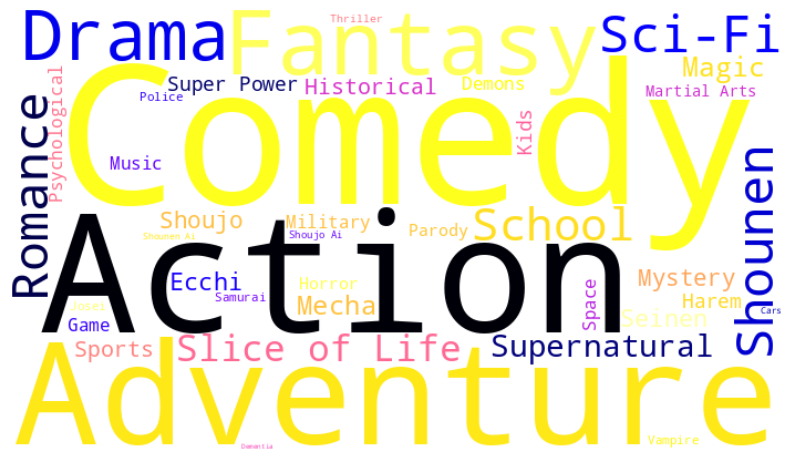

['Action',
 ' Military',
 ' Adventure',
 ' Comedy',
 ' Drama',
 ' Magic',
 ' Fantasy',
 ' Shounen',
 'Action',
 ' Military',
 ' Mystery',
 ' Super Power',
 ' Drama',
 ' Fantasy',
 ' Shounen',
 'Thriller',
 ' Sci-Fi',
 'Action',
 ' Drama',
 ' Fantasy',
 ' Military',
 ' Mystery',
 ' Shounen',
 ' Super Power',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Action',
 ' Adventure',
 ' Fantasy',
 ' Shounen',
 ' Super Power',
 'Action',
 ' Sci-Fi',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Shounen',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Drama',
 ' Game',
 ' Seinen',
 ' Slice of Life',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Slice of Life',
 ' Comedy',
 ' Supernatural',
 ' Drama',
 ' Romance',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Mystery',
 ' Comedy',
 ' Supernatural',
 ' Vampire',

In [202]:
def get_favorite_genre(frame, plot=False):
    frame.dropna(inplace=True)

    all_genres = defaultdict(int)

    genres_list = []

    for genres in frame['Genres']:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
        
    if plot:
        show_word_cloud(all_genres)

    return genres_list

get_favorite_genre(df, plot=True)


In [203]:
x = get_anime_frame('Steins;Gate', df)
print(x)
get_favorite_genre(x)

      anime_id  eng_version Score  ... Type    Premiered  Members
5683      9253  Steins;Gate  9.11  ...   TV  Spring 2011  1771162

[1 rows x 8 columns]


/var/folders/88/1yyncvfs0lxbyvhsl_fzsdlr0000gn/T/ipykernel_24849/452906021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame.dropna(inplace=True)


['Thriller', ' Sci-Fi']

In [204]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [205]:
def get_user_preference(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df['user_id'] == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user['rating'], 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user['rating'] >= user_rating_percentile]

    top_animes_from_user = (
        animes_watched_by_user.sort_values(by='rating', ascending=False).anime_id.values
    )

    anime_df_rows = df[df['anime_id'].isin(top_animes_from_user)]
    anime_df_rows = anime_df_rows[['eng_version', 'Genres']]

    if plot:
        get_favorite_genre(anime_df_rows, plot=True)

    return anime_df_rows
      

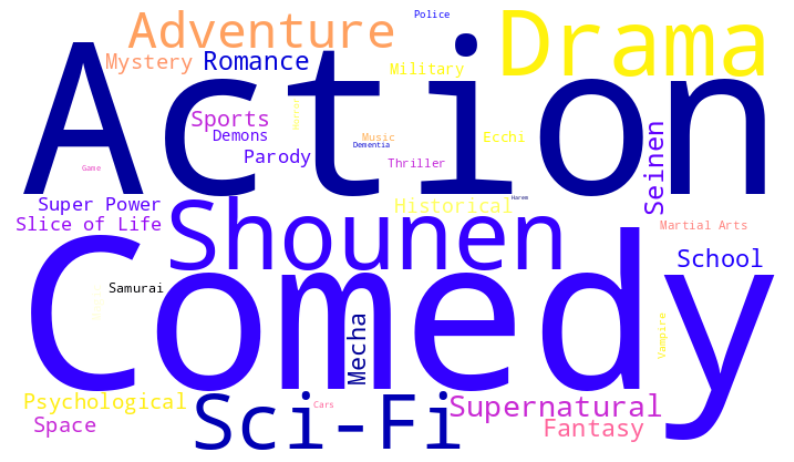

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
...,...,...
6624,Nyaruko:Crawling With Love!,"Sci-Fi, Comedy, Parody"
8759,Terraformars,"Action, Sci-Fi, Space, Horror, Drama, Seinen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [206]:
get_user_preference(11880, rating_df, df, plot=True)

In [211]:
def get_user_recommendation(similar_users, user_preferences, df, synopsis_df, rating_df, n=10, verbose=0):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users['similar_users'].values:
        pref_list = get_user_preference(int(user_id), rating_df, df)
        
        pref_list = pref_list[~pref_list['eng_version'].isin(user_preferences['eng_version'])]

        if not pref_list.empty:
            anime_list.append(pref_list['eng_version'].values)


    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0]

            if isinstance(anime_name, str):
                frame = get_anime_frame(anime_name, df)

                anime_id = frame.anime_id.values[0]
                synopsis = get_synopsis(int(anime_id), synopsis_df)
                genre = frame.Genres.values[0]

                recommended_animes.append({
                    'n': n_user_pref[0],
                    'anime_name': anime_name,
                    'Synopsis': synopsis,
                    'Genres': genre,
                })

    return pd.DataFrame(recommended_animes).head(n)

In [212]:
similar_users = find_similar_users(int(11880), user_weights, user_to_user_encoded, user_to_user_decoded)
user_preferences = get_user_preference(int(11880), rating_df, df, plot=False)

get_user_recommendation(similar_users, user_preferences, df, synopsis_df, rating_df, n=10, verbose=0)

,n,anime_name,Synopsis,Genres
0,10,Soul Eater,"Death City is home to the famous Death Weapon Meister Academy, a technical academy headed by the Shinigami—Lord Death himself. Its mission: to raise ""Death Scythes"" for the Shinigami to wield against the many evils of their fantastical world. These Death Scythes, however, are not made from physical weapons; rather, they are born from human hybrids who have the ability to transform their bodies into Demon Weapons, and only after they have consumed the souls of 99 evil beings and one witch's soul. Soul Eater Evans, a Demon Scythe who only seems to care about what's cool, aims to become a Death Scythe with the help of his straight-laced wielder, or meister, Maka Albarn. The contrasting duo work and study alongside the hot headed Black☆Star and his caring weapon Tsubaki, as well as the Shinigami's own son, Death the Kid, an obsessive-compulsive dual wielder of twin pistols Patty and Liz. Soul Eater follows these students of Shibusen as they take on missions to collect souls and protect the city from the world's threats while working together under the snickering sun to become sounder in mind, body, and soul.","Action, Fantasy, Comedy, Supernatural, Shounen"
1,9,Angel Beats!,"Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife.","Action, Comedy, Drama, School, Supernatural"
2,9,Toradora!,"uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process.","Slice of Life, Comedy, Romance, School"
3,9,Death Note,"shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a you

### HYBRID RECOMMENDATION SYSTEM

In [228]:
def hybrid_recommendation(user_id, collaborative_weight = 0.5, content_weight = 0.5):
    # Use global user_weights (embedding weights) for find_similar_users
    similar_users = find_similar_users(user_id, user_weights, user_to_user_encoded, user_to_user_decoded)
    
    # Check if similar_users is empty
    if similar_users.empty or 'similar_users' not in similar_users.columns:
        print(f"Warning: No similar users found for user_id {user_id}")
        return []
    
    user_preferences = get_user_preference(user_id, rating_df, df, plot=False)
    user_recommended_animes = get_user_recommendation(similar_users, user_preferences, df, synopsis_df, rating_df)
    
    # Check if user_recommended_animes is empty
    if user_recommended_animes.empty or 'anime_name' not in user_recommended_animes.columns:
        print(f"Warning: No recommendations found for user_id {user_id}")
        return []
    
    user_recommended_anime_list = user_recommended_animes['anime_name'].tolist()

    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime_to_anime_encoded, anime_to_anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes['name'].tolist())
        
        else:
            print(f'No similar animes found for {anime}')

    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + collaborative_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]

    
    
    
    
    



    

In [237]:
hybrid_recommendation(15597, 0, 1)

['Seven Mortal Sins',
 'My Teen Romantic Comedy SNAFU',
 'Super GALS!',
 'Cute High Earth Defense Club LOVE!',
 'Hyouka',
 "Stella Women's Academy, High School Division Class C³",
 'Superbook 2',
 'When They Cry',
 'Bucky:The Incredible Kid',
 'Power Stone']